## 코스피 업종/종목별 수익률 TREE MAP
1. 주가 데이터 수집(파이썬)
   - 구글 파이낸스
   - 수익률 : 6월(=6월말 종가/5월말 종가 - 1)  
2. 시가총액(파이썬)
   - 네이버 증권 기준
3. 종목 업종(파이썬) 
   - 네이버 증권 기준
4. 차트 작성
   - 업종/종목별 트리맵(R)
5. 출처 
   - https://finviz.com/map.ashx
---

In [ ]:
library(treemap)
library(dplyr)
library(ggplot2)

library(extrafont) # 차트에 한글을 쓴다면...
loadfonts("win")

In [2]:
# 파이썬 웹크롤링 데이터 읽기 
  # sector : 업종구분(네이버)
  # ret : 6월 수익률
  # amt_price : 시가총액(천억)
  # amt_price_log : 시가총액(천억 로그 변환)
df1 <- read.csv('C:\\stock_df1.csv', stringsAsFactors=FALSE)  # 코스피 전 종목
head(df1)

code,stock,industry,group1,sector,ret,amt_price,amt_price_log
030720.KS,동원수산,어업,KOSPI,식품,0.05251641,388,2.588832
007160.KS,사조산업,어업,KOSPI,식품,0.04960836,3810,3.580925
006040.KS,동원산업,어업,KOSPI,식품,-0.04579025,10510,4.021603
004970.KS,신라교역,어업,KOSPI,식품,0.01346801,2384,3.377306
006090.KS,사조오양,어업,KOSPI,식품,0.02950820,1451,3.161667
003580.KS,동원,광업,KOSPI,건축자재,-0.08477842,917,2.962369


In [27]:
# 수치형 데이터 분포 확인
summary(df1[,6:8])

      ret              amt_price       amt_price_log  
 Min.   :-0.537892   Min.   :    108   Min.   :2.033  
 1st Qu.:-0.052571   1st Qu.:   1204   1st Qu.:3.081  
 Median :-0.008082   Median :   2793   Median :3.446  
 Mean   : 0.002927   Mean   :  25675   Mean   :3.598  
 3rd Qu.: 0.040550   3rd Qu.:   9846   3rd Qu.:3.993  
 Max.   : 0.895369   Max.   :3070710   Max.   :6.487  

In [40]:
# 업종별 집계
df_sum <- df1 %>% group_by(sector) %>% 
                  summarise(ret = mean(ret)*100, stock_counts = n()) %>%
                  arrange(desc(stock_counts))        
df_sum$pos <- df_sum$ret >= 0     # 수익률 음양 구분하기(추후 막대그래프 색깔 구분)
head(df_sum,10)

sector,ret,stock_counts,pos
화학,2.1138800,74,TRUE
자동차부품,-0.1407153,67,FALSE
식품,-3.7258657,56,FALSE
제약,-0.8225411,54,FALSE
"섬유,의류,신발,호화품",-1.8906968,50,FALSE
건설,-5.0351806,43,FALSE
건축자재,-1.9765181,32,FALSE
기계,1.1449634,32,TRUE
증권,13.9261136,32,TRUE
철강,2.1628296,31,TRUE


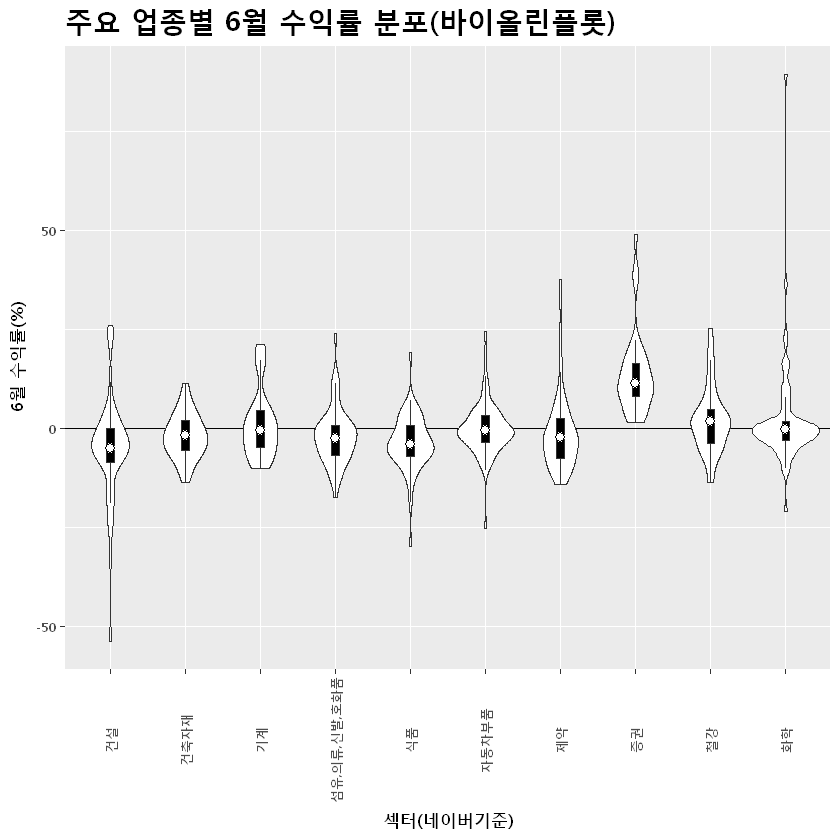

In [74]:
df_violin <- df1 %>% filter(sector %in% c('화학','자동차부품','식품','제약','섬유,의류,신발,호화품',
                                          '건설','건축자재','기계','증권','철강'))
p <- ggplot(df_violin, aes(x=sector, y=ret*100)) + 
        geom_hline(yintercept=0) +
        geom_violin() + 
        geom_boxplot(width=.1, fill='black', outlier.colour=NA) +
        stat_summary(fun.y=median, geom='point', fill='white', shape=21, size=2.5) + 
        xlab("섹터(네이버기준)") + ylab("6월 수익률(%)")
        
p + ggtitle("주요 업종별 6월 수익률 분포(바이올린플롯)") +
    theme(plot.title=element_text(size=rel(1.5), family="Malgun Gothic", face="bold")) +
    theme(axis.title.x=element_text(size=10, family="Malgun Gothic", face="bold")) +
    theme(axis.title.y=element_text(size=10, family="Malgun Gothic", face="bold")) +
    theme(axis.text.x=element_text(size=8, family="Malgun Gothic", face="bold", angle=90, vjust=0.5)) +    
    theme(axis.text.y=element_text(size=8, family="Malgun Gothic", face="bold")) 

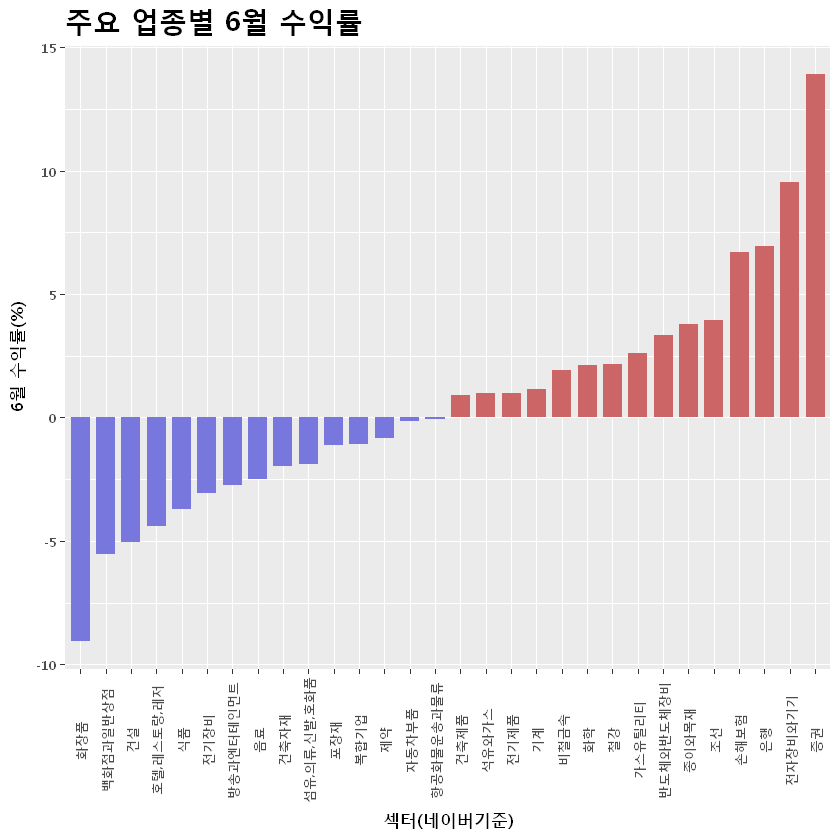

In [67]:
df_sum_main <- head(df_sum,30) %>% arrange(desc(ret))
p <- ggplot(df_sum_main, aes(x=reorder(sector, ret), y=ret, fill=pos)) +
        geom_bar(stat='identity', width=0.75) +
        scale_fill_manual(values=c('#7777DD','#CC6666'), guide=FALSE) +
        xlab("섹터(네이버기준)") + ylab("6월 수익률(%)")
        
p + ggtitle("주요 업종별 6월 수익률") +
    theme(plot.title=element_text(size=rel(1.5), family="Malgun Gothic", face="bold")) +
    theme(axis.title.x=element_text(size=10, family="Malgun Gothic", face="bold")) +
    theme(axis.title.y=element_text(size=10, family="Malgun Gothic", face="bold")) +
    theme(axis.text.x=element_text(size=8, family="Malgun Gothic", face="bold", angle=90, vjust=0.5)) +    
    theme(axis.text.y=element_text(size=8, family="Malgun Gothic", face="bold")) 

---
### 여기서부터 트리맵 그리기
1. 우선주는 두번 그려지므로 제외 
2. 값 범위 조정 : 상한/하한 +/- 20%로 제한
3. 색깔 범례 : 상승 -> 빨간색, 하락 -> 파란색, 보합 -> 회색 
---

In [3]:
# 우선주 처리 방법 : 종목 끝글자 우 또는 B => 미래에셋대우, 동원F&B는 예외처리
df1$last_ch_1 <- substr(df1$stock, nchar(df1$stock), nchar(df1$stock))
df1$last_ch_2 <- substr(df1$stock, nchar(df1$stock)-1, nchar(df1$stock))

df1$preferred_stock <- ifelse(df1$last_ch_1 %in% c('우','B'), 1, 0 )
df1$preferred_stock <- ifelse(df1$stock %in% c('미래에셋대우', '동원F&B'), 0, df1$preferred_stock )

# 상한하한을 20%로 잡아주고, 곱하기 100
df1$ret2 <- ifelse(df1$ret < -0.2, -0.2,
                   ifelse(df1$ret > 0.2, 0.2, df1$ret )) * 100

In [4]:
# RGB 코드 테이블 : http://www.rapidtables.com/web/color/RGB_Color.htm
# 빨간색>상승, 회색>보합, 파란색>하락
cp_palette <- c("#87CEEB","#6495ED","#0000FF","#191970",
                "#404040",
                "#800000","#A52A2A","#FF0000","#FF9999")

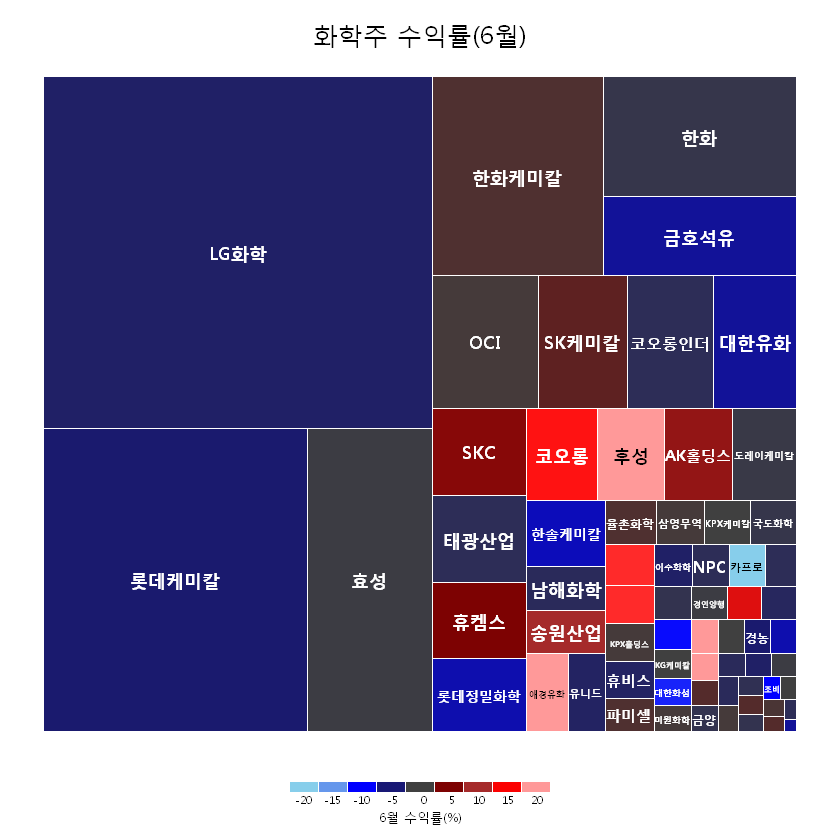

In [10]:
df_sub <- df1 %>% filter(sector == '화학' & preferred_stock == 0)
                
treemap(df_sub,
        index=c("stock"),    
        vSize="amt_price",            # 크기 : 시가총액
        vColor="ret2",                # 컬러 : 수익률
        type="value",        
        palette=cp_palette,           # 빨간색>상승, 회색>보합, 파란색>하락
        range=c(-20, 20),             # 값 범위 : +- 20%
        border.col='white',           # 경계선 : 흰색
        border.lwds=1,                # 경계선 얇게
        title='화학주 수익률(6월)',     # 제목 없애기
        fontsize.title = 15,
        title.legend='6월 수익률(%)',  # 범례 제목 추가
        fontsize.legend=8,            # 범례 글자 크기 작게
        fontfamily.title = "Malgun Gothic",   # 폰트
        fontfamily.labels = "Malgun Gothic",
        fontfamily.legend = "Malgun Gothic")

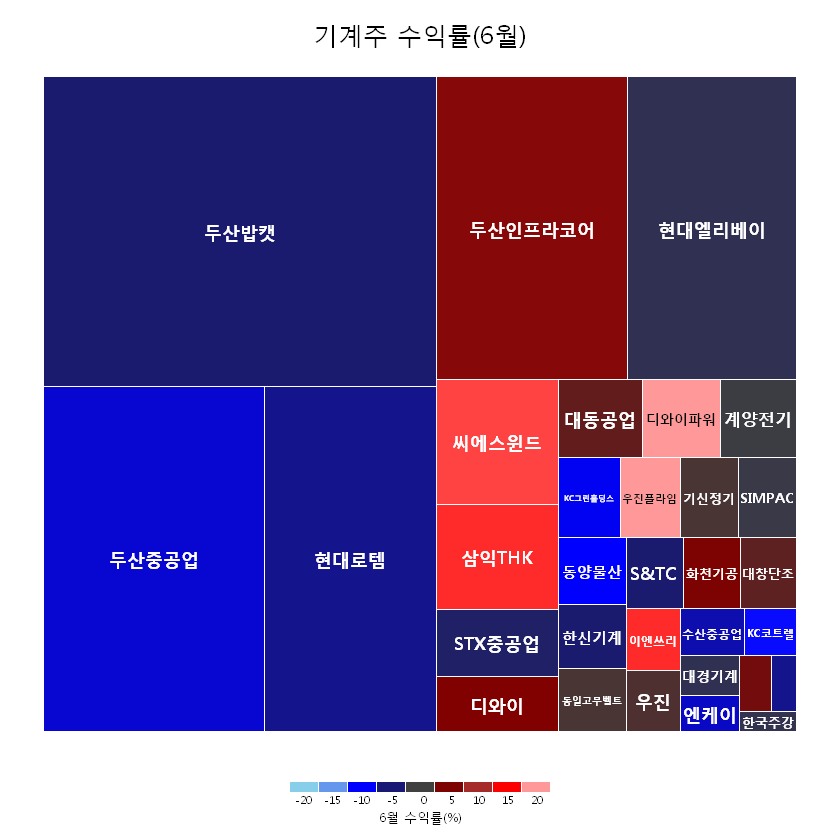

In [13]:
df_sub <- df1 %>% filter(sector == '기계' & preferred_stock == 0)

treemap(df_sub,
        index=c("stock"),    
        vSize="amt_price",            # 크기 : 시가총액
        vColor="ret2",                # 컬러 : 수익률
        type="value",        
        palette=cp_palette,           # 빨간색>상승, 회색>보합, 파란색>하락
        range=c(-20, 20),             # 값 범위 : +- 20%
        border.col='white',           # 경계선 : 흰색
        border.lwds=1,                # 경계선 얇게
        title='기계주 수익률(6월)',     # 제목 없애기
        fontsize.title = 15,
        title.legend='6월 수익률(%)',  # 범례 제목 추가
        fontsize.legend=8,            # 범례 글자 크기 작게
        fontfamily.title = "Malgun Gothic",   # 폰트
        fontfamily.labels = "Malgun Gothic",
        fontfamily.legend = "Malgun Gothic")

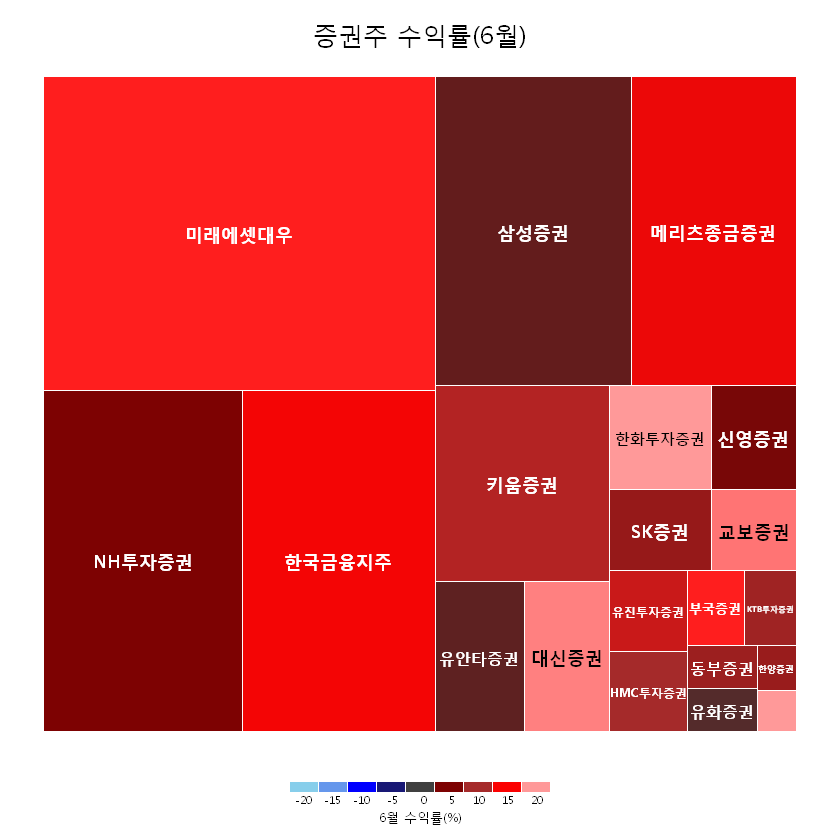

In [15]:
df_sub <- df1 %>% filter(sector == '증권' & preferred_stock == 0)

treemap(df_sub,
        index=c("stock"),    
        vSize="amt_price",            # 크기 : 시가총액
        vColor="ret2",                # 컬러 : 수익률
        type="value",        
        palette=cp_palette,           # 빨간색>상승, 회색>보합, 파란색>하락
        range=c(-20, 20),             # 값 범위 : +- 20%
        border.col='white',           # 경계선 : 흰색
        border.lwds=1,                # 경계선 얇게
        title='증권주 수익률(6월)',     # 제목 없애기
        fontsize.title = 15,
        title.legend='6월 수익률(%)',  # 범례 제목 추가
        fontsize.legend=8,            # 범례 글자 크기 작게
        fontfamily.title = "Malgun Gothic",   # 폰트
        fontfamily.labels = "Malgun Gothic",
        fontfamily.legend = "Malgun Gothic")

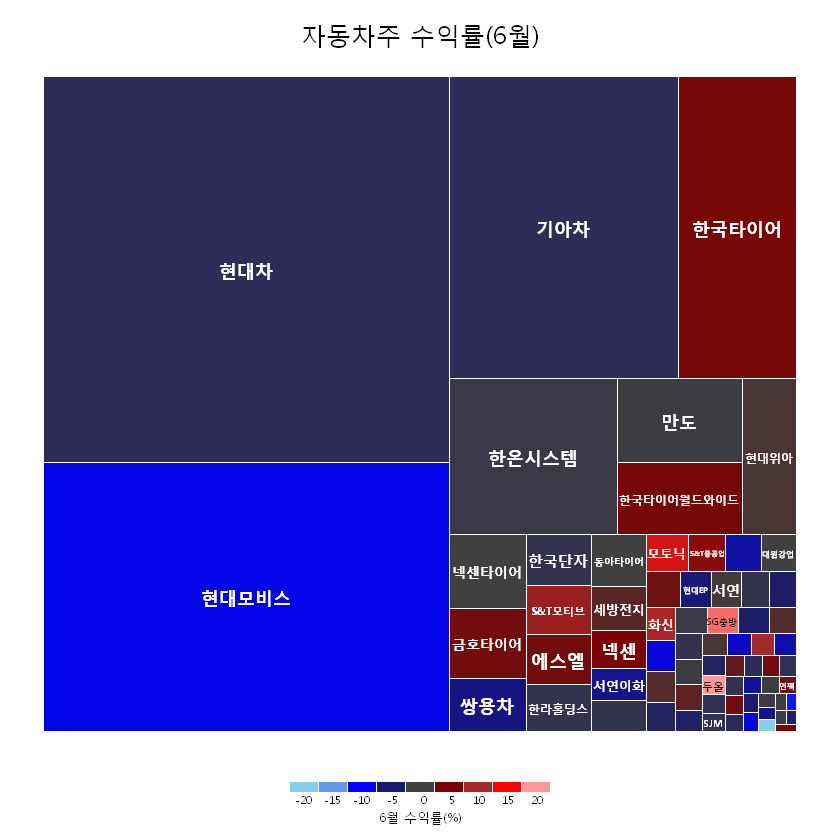

In [17]:
df_sub <- df1 %>% filter(sector %in% c('자동차','자동차부품') & preferred_stock == 0)

treemap(df_sub,
        index=c("stock"),    
        vSize="amt_price",            # 크기 : 시가총액
        vColor="ret2",                # 컬러 : 수익률
        type="value",        
        palette=cp_palette,           # 빨간색>상승, 회색>보합, 파란색>하락
        range=c(-20, 20),             # 값 범위 : +- 20%
        border.col='white',           # 경계선 : 흰색
        border.lwds=1,                # 경계선 얇게
        title='자동차주 수익률(6월)',     # 제목 없애기
        fontsize.title = 15,
        title.legend='6월 수익률(%)',  # 범례 제목 추가
        fontsize.legend=8,            # 범례 글자 크기 작게
        fontfamily.title = "Malgun Gothic",   # 폰트
        fontfamily.labels = "Malgun Gothic",
        fontfamily.legend = "Malgun Gothic")

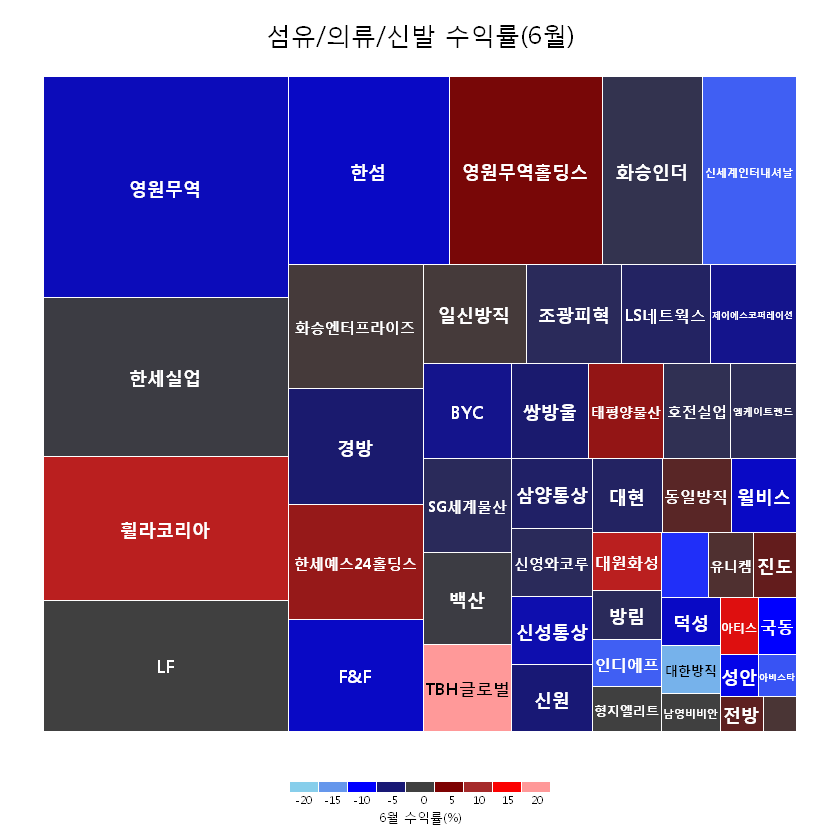

In [6]:
df_sub <- df1 %>% filter(sector == '섬유,의류,신발,호화품' & preferred_stock == 0)

treemap(df_sub,
        index=c("stock"),    
        vSize="amt_price",            # 크기 : 시가총액
        vColor="ret2",                # 컬러 : 수익률
        type="value",        
        palette=cp_palette,           # 빨간색>상승, 회색>보합, 파란색>하락
        range=c(-20, 20),             # 값 범위 : +- 20%
        border.col='white',           # 경계선 : 흰색
        border.lwds=1,                # 경계선 얇게
        title='섬유/의류/신발 수익률(6월)',  # 제목
        fontsize.title = 15,
        title.legend='6월 수익률(%)',  # 범례 제목 추가
        fontsize.legend=8,            # 범례 글자 크기 작게
        fontfamily.title = "Malgun Gothic",   # 폰트
        fontfamily.labels = "Malgun Gothic",
        fontfamily.legend = "Malgun Gothic")

---
### [참고] 파이썬 웹 크롤링 코드
---

In [ ]:
# 라이브러리 
import pandas as pd
from pandas_datareader import data, wb
import pandas_datareader.data as web

import numpy as np

from datetime import datetime, timedelta
import time

from bs4 import BeautifulSoup
import requests

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams, style
style.use('ggplot')
matplotlib.rc('font', family='Malgun Gothic')  # 차트에 한글 사용
# %matplotlib inline


#1 코스피 종목 정보 읽기
kospi = pd.read_csv('C:\\Users\\user\kospi_20170502.crm', sep='\t', header=None)
kospi.columns = ['code', 'stock','industry']
kospi['group1'] = 'KOSPI'

symbols = kospi['code'].map(lambda x: 'KRX:' + x[:6])


#2. 6월 수익률 계산
st_dt = '2017-05-31'
ed_dt = '2017-06-30'
ret_close = []
for i, s in enumerate(symbols):
    try:
        close_st = web.DataReader(s, 'google', st_dt, st_dt)['Close'] 
        close_ed = web.DataReader(s, 'google', ed_dt, ed_dt)['Close'] 
        ret = close_ed[0] / close_st[0] - 1        
    except:
        print("Error in : {}, {}" .format(s, kospi['stock'][i]))
        ret = np.nan
        
    ret_close.append(ret)
    time.sleep(5)
    
    

#3. 시가총액 스크래핑
def css_out(css):
    return [ x.text.strip() for x in soup.select(css)]

amt_price = []
for i, s in enumerate(kospi['code']):    
    try:
        # url = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=006800'
        url = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=' + s[:6]
        html = requests.get(url).text
        soup = BeautifulSoup(html, "html5lib")
        temp_var1 = css_out("td.num")[4]
        temp_var2 = int( temp_var1.replace('억원','').replace(',','') )  # 정수형 변환
        amt_price.append(temp_var2)
    except:
        print("Error in : {}, {}" .format(s, kospi['stock'][i]))
        amt_price.append(np.nan) 
        
    time.sleep(5)
        
#4. 네이버 업종명 스크래핑
sector_naver = []
for i, s in enumerate(kospi['code']):    
    try:
        url = 'http://finance.naver.com/item/main.nhn?code=' + s[:6]
        html = requests.get(url).text
        soup = BeautifulSoup(html, "html5lib")
        temp_var = css_out("h4.h_sub.sub_tit7 em a")[0]
        sector_naver.append(temp_var)
    except:
        print("Error in : {}, {}" .format(s, kospi['stock'][i]))
        sector_naver.append(None)
        
    time.sleep(5)
    
    
    

#4. 최종 데이터 생성
df = pd.concat([kospi, 
                pd.Series(sector_naver),
                pd.Series(ret_close),
                pd.Series(amt_price)], axis=1)
    
df.columns = ['code','stock','industry','group1','sector','ret','amt_price']    
   
df.describe()

              

#5. 분포 확인 후 
#   null 종목 제거
#   시가총액 -> 로그 변환 추가
#   csv파일로 저장
df['ret'].isnull().sum()
df['amt_price'].isnull().sum()

df.dropna(inplace=True) # 결측값 날리기

df['ret'].plot.hist(bins=30, alpha=0.5)
df['amt_price'].plot.hist(bins=30, alpha=0.5)
np.log10(df['amt_price']).plot.hist(alpha=0.5)

df['amt_price_log'] = np.log10(df['amt_price'])

df.corr()

grouped_ret_mean = df.groupby('sector')['ret'].mean()
grouped_ap_mean = df.groupby('sector')['amt_price'].mean()
grouped_count = df.groupby('sector')['ret'].count()

df_sum = pd.concat([grouped_ret_mean, grouped_ap_mean, grouped_count], axis=1)
df_sum.columns = ['ret_mean','amt_price_mean','counts']
df_sum.sort_values(by='ret_mean', ascending=False, inplace=True)


df.to_csv('C:\\stock_df1.csv', index=False)
df_sum.to_csv('C:\\stock_df2.csv')


## seaborn 한글이 안됨 ##
import seaborn as sns
sns.set_style("whitegrid")
ax = sns.swarmplot(x=df["ret"])

ax = sns.swarmplot(x="sector", y="ret", data=df)
ax = sns.swarmplot(x="sector", y="ret", 
                   data=df[ df['sector'].isin( ['화학','자동차부품','식품','제약','건설','기계','증권'] ) ])